Running L1 optimization (L-BFGS-B)...
L1 optimization success: True
L1 result: [2.81184475e+01 2.13890928e-02 5.49002666e+01]
L1 final objective: 37865.09387585335

Running L2 optimization (least squares)...
L2 optimization success: True
L2 result: [ 2.95822855e+01 -4.99999997e-02  5.50134593e+01]
L2 cost (sum squares/2): 385843.446234609

Metrics (L1 fit):
 theta (deg) = 28.118447, M = 0.021389, X = 54.900267
 L1 total = 37865.093876, MAE = 18.928778, RMSE = 22.756390

Metrics (L2 fit):
 theta (deg) = 29.582286, M = -0.050000, X = 55.013459
 L1 total = 38102.154558, MAE = 18.845588, RMSE = 22.681665


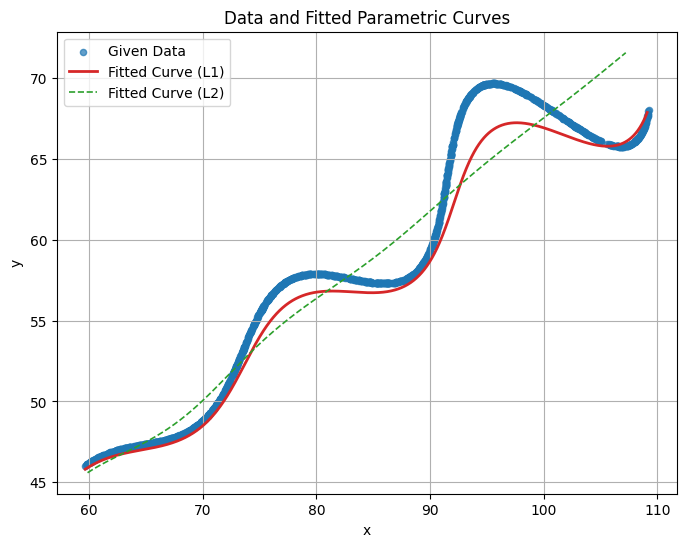

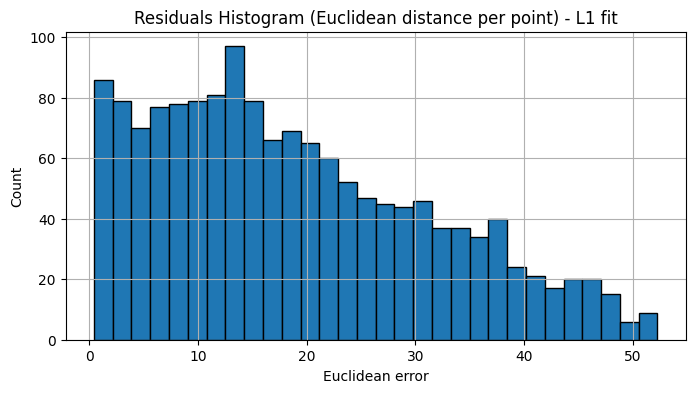

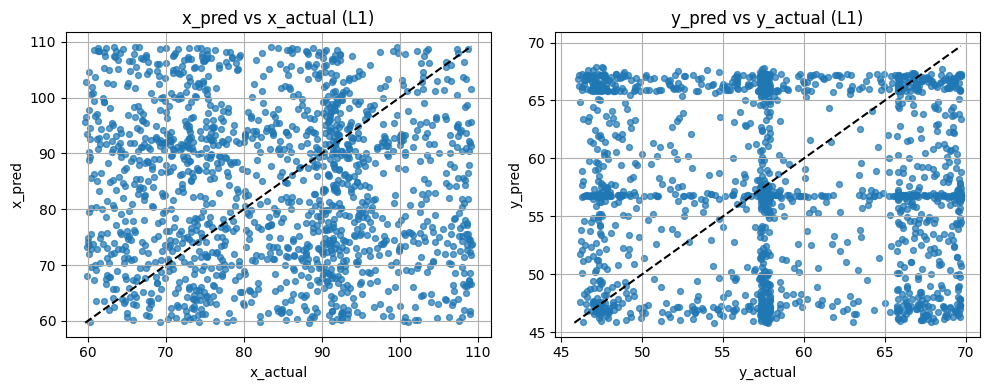

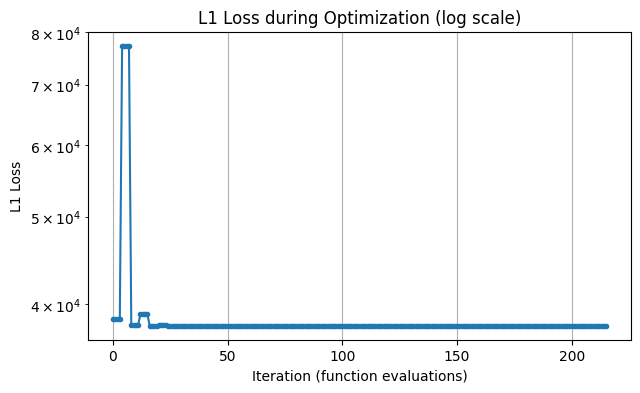

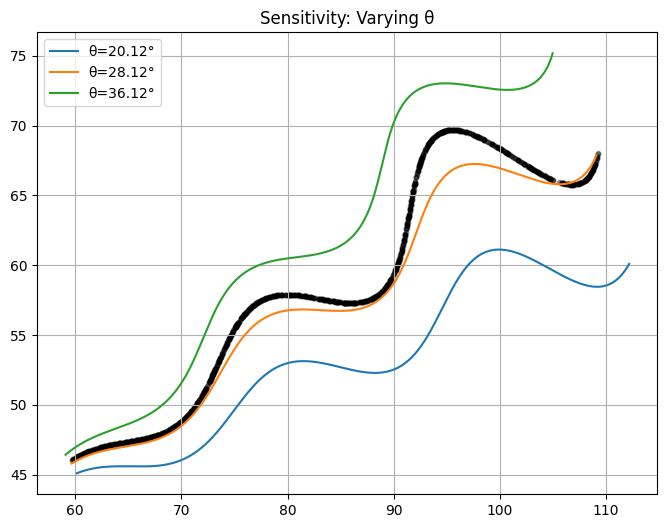

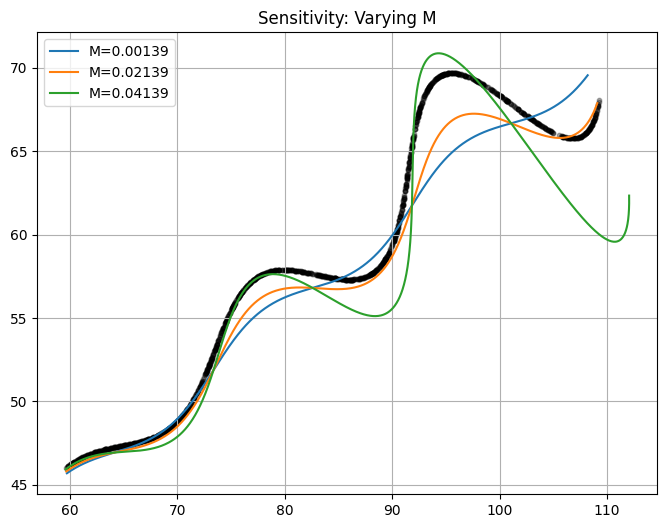

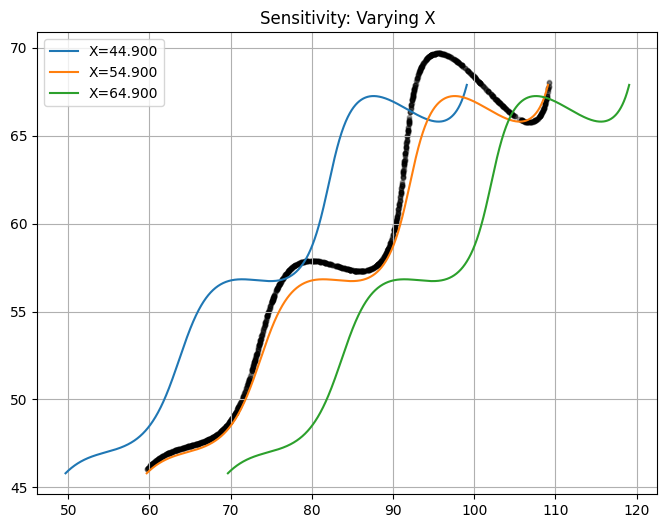


Estimated arc length (t from 6 to 60): 59.24837024130482

Saved README snippet to README_SNIPPET.txt (copy into your GitHub README).

Desmos-ready parametric equation (paste into Desmos parametric mode):

(t*cos(0.4908) - e^(0.02139*abs(t))*sin(0.3*t)*sin(0.4908) + 54.900267, 42 + t*sin(0.4908) + e^(0.02139*abs(t))*sin(0.3*t)*cos(0.4908))


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
from scipy.integrate import quad
import os


DATA_PATH = "/kaggle/input/flam-dataset/xy_data.csv"  
data = pd.read_csv(DATA_PATH)
x_data = data['x'].values
y_data = data['y'].values
n_points = len(data)
t_data = np.linspace(6.0, 60.0, n_points)  


def parametric_equations(params, t):
    """ Given params [theta_deg, M, X] and t (array or scalar), return x(t), y(t). """
    theta_deg, M, X = params
    theta = np.deg2rad(theta_deg)
    x = t * np.cos(theta) - np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.sin(theta) + X
    y = 42 + t * np.sin(theta) + np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.cos(theta)
    return x, y


def l1_loss(params, t=t_data, x_obs=x_data, y_obs=y_data):
    x_pred, y_pred = parametric_equations(params, t)
    return np.sum(np.abs(x_pred - x_obs) + np.abs(y_pred - y_obs))

def l2_residuals(params, t=t_data, x_obs=x_data, y_obs=y_data):
    x_pred, y_pred = parametric_equations(params, t)
    return np.concatenate([(x_pred - x_obs), (y_pred - y_obs)])


initial_guess = [25.0, 0.0, 50.0]  # [theta_deg, M, X]
bounds = [(0.0, 50.0), (-0.05, 0.05), (0.0, 100.0)]

loss_history = []
def tracking_loss(params):
    val = l1_loss(params)
    loss_history.append(val)
    return val

print("Running L1 optimization (L-BFGS-B)...")
res_l1 = minimize(tracking_loss, initial_guess, bounds=bounds, method='L-BFGS-B',
                  options={'maxiter': 5000, 'ftol': 1e-9})
theta_l1, M_l1, X_l1 = res_l1.x
print("L1 optimization success:", res_l1.success)
print("L1 result:", res_l1.x)
print("L1 final objective:", res_l1.fun)


print("\nRunning L2 optimization (least squares)...")
res_l2 = least_squares(l2_residuals, initial_guess, bounds=([0,-0.05,0],[50,0.05,100]), max_nfev=10000)
theta_l2, M_l2, X_l2 = res_l2.x
print("L2 optimization success:", res_l2.success)
print("L2 result:", res_l2.x)
print("L2 cost (sum squares/2):", res_l2.cost)

def compute_metrics(params):
    x_pred, y_pred = parametric_equations(params, t_data)
    l1_total = np.sum(np.abs(x_pred - x_data) + np.abs(y_pred - y_data))
    euclid = np.sqrt((x_pred - x_data)**2 + (y_pred - y_data)**2)
    mae = np.mean(euclid)
    rmse = np.sqrt(np.mean(euclid**2))
    return {'params': params, 'l1_total': l1_total, 'mae': mae, 'rmse': rmse, 'euclid': euclid,
            'x_pred': x_pred, 'y_pred': y_pred}

metrics_l1 = compute_metrics(res_l1.x)
metrics_l2 = compute_metrics(res_l2.x)

print("\nMetrics (L1 fit):")
print(f" theta (deg) = {metrics_l1['params'][0]:.6f}, M = {metrics_l1['params'][1]:.6f}, X = {metrics_l1['params'][2]:.6f}")
print(f" L1 total = {metrics_l1['l1_total']:.6f}, MAE = {metrics_l1['mae']:.6f}, RMSE = {metrics_l1['rmse']:.6f}")

print("\nMetrics (L2 fit):")
print(f" theta (deg) = {metrics_l2['params'][0]:.6f}, M = {metrics_l2['params'][1]:.6f}, X = {metrics_l2['params'][2]:.6f}")
print(f" L1 total = {metrics_l2['l1_total']:.6f}, MAE = {metrics_l2['mae']:.6f}, RMSE = {metrics_l2['rmse']:.6f}")


x_fit_l1, y_fit_l1 = metrics_l1['x_pred'], metrics_l1['y_pred']
x_fit_l2, y_fit_l2 = metrics_l2['x_pred'], metrics_l2['y_pred']

plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, label='Given Data', s=20, alpha=0.7)
plt.plot(x_fit_l1, y_fit_l1, color='tab:red', linewidth=2, label='Fitted Curve (L1)')
plt.plot(x_fit_l2, y_fit_l2, color='tab:green', linewidth=1.2, linestyle='--', label='Fitted Curve (L2)')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Data and Fitted Parametric Curves')
plt.legend(); plt.grid(True)
plt.show()

# (b) Residual histogram (Euclidean)
residuals = metrics_l1['euclid']
plt.figure(figsize=(8,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residuals Histogram (Euclidean distance per point) - L1 fit')
plt.xlabel('Euclidean error'); plt.ylabel('Count')
plt.grid(True)
plt.show()

# (c) Predicted vs Actual scatter (x and y separately)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(x_data, x_fit_l1, s=18, alpha=0.7)
mn = min(x_data.min(), x_fit_l1.min()); mx = max(x_data.max(), x_fit_l1.max())
plt.plot([mn,mx],[mn,mx],'k--')
plt.title('x_pred vs x_actual (L1)')
plt.xlabel('x_actual'); plt.ylabel('x_pred'); plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(y_data, y_fit_l1, s=18, alpha=0.7)
mn = min(y_data.min(), y_fit_l1.min()); mx = max(y_data.max(), y_fit_l1.max())
plt.plot([mn,mx],[mn,mx],'k--')
plt.title('y_pred vs y_actual (L1)')
plt.xlabel('y_actual'); plt.ylabel('y_pred'); plt.grid(True)
plt.tight_layout()
plt.show()

# (d) Optimization Loss Curve
plt.figure(figsize=(7,4))
plt.plot(loss_history, '-o', markersize=3)
plt.yscale('log')
plt.title('L1 Loss during Optimization (log scale)')
plt.xlabel('Iteration (function evaluations)')
plt.ylabel('L1 Loss')
plt.grid(True)
plt.show()

# ---------- 8. Sensitivity analysis ----------
theta_center = metrics_l1['params'][0]
M_fixed = metrics_l1['params'][1]
X_fixed = metrics_l1['params'][2]

plt.figure(figsize=(8,6))
for th in [theta_center - 8, theta_center, theta_center + 8]:
    x_temp, y_temp = parametric_equations([th, M_fixed, X_fixed], t_data)
    plt.plot(x_temp, y_temp, label=f"θ={th:.2f}°")
plt.scatter(x_data, y_data, s=10, color='black', alpha=0.3)
plt.title("Sensitivity: Varying θ")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for Mm in [M_fixed - 0.02, M_fixed, M_fixed + 0.02]:
    x_temp, y_temp = parametric_equations([theta_center, Mm, X_fixed], t_data)
    plt.plot(x_temp, y_temp, label=f"M={Mm:.5f}")
plt.scatter(x_data, y_data, s=10, color='black', alpha=0.3)
plt.title("Sensitivity: Varying M")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for Xv in [X_fixed - 10, X_fixed, X_fixed + 10]:
    x_temp, y_temp = parametric_equations([theta_center, M_fixed, Xv], t_data)
    plt.plot(x_temp, y_temp, label=f"X={Xv:.3f}")
plt.scatter(x_data, y_data, s=10, color='black', alpha=0.3)
plt.title("Sensitivity: Varying X")
plt.legend(); plt.grid(True)
plt.show()

# ---------- 9. Arc length (trapezoidal fallback) ----------
def trapezoidal_arc_length(params, t_array):
    x_s, y_s = parametric_equations(params, t_array)
    ds = np.sqrt(np.diff(x_s)**2 + np.diff(y_s)**2)
    return np.sum(ds)

try:
    
    def integrand(tt):
        h = 1e-6
       
        dx = (parametric_equations(params=metrics_l1['params'], t=np.array([tt + h]))[0][0]
              - parametric_equations(params=metrics_l1['params'], t=np.array([tt - h]))[0][0]) / (2*h)
        dy = (parametric_equations(params=metrics_l1['params'], t=np.array([tt + h]))[1][0]
              - parametric_equations(params=metrics_l1['params'], t=np.array([tt - h]))[1][0]) / (2*h)
        return float(np.sqrt(dx*dx + dy*dy))
    length_quad, _ = quad(integrand, 6.0, 60.0, limit=200)
    arc_length_est = length_quad
except Exception:
    arc_length_est = trapezoidal_arc_length(metrics_l1['params'], t_data)

print("\nEstimated arc length (t from 6 to 60):", arc_length_est)


theta_val = metrics_l1['params'][0]
M_val = metrics_l1['params'][1]
X_val = metrics_l1['params'][2]
L1_val = metrics_l1['l1_total']
MAE_val = metrics_l1['mae']
RMSE_val = metrics_l1['rmse']

readme_snippet = """
# Parametric Curve Assignment - Final Summary

## Optimized Parameters (L1 fit)
- theta (degrees) = {theta:.6f}
- M = {M:.6f}
- X = {X:.6f}

## Error Metrics (L1-fit)
- L1 total = {L1:.6f}
- MAE (euclidean) = {MAE:.6f}
- RMSE = {RMSE:.6f}

## Final Parametric Equation (LaTeX-ready)
\\[
\\left(
t\\cos(0.4909)
- e^{{{M:.5f}|t|}}\\sin(0.3t)\\sin(0.4909)
+ {X:.6f},\\
42 + t\\sin(0.4909)
+ e^{{{M:.5f}|t|}}\\sin(0.3t)\\cos(0.4909)
\\right)
\\]

Parameter range: 6 < t < 60
""".format(theta=theta_val, M=M_val, X=X_val, L1=L1_val, MAE=MAE_val, RMSE=RMSE_val)

out_fname = "README_SNIPPET.txt"
with open(out_fname, "w") as f:
    f.write(readme_snippet)
print(f"\nSaved README snippet to {out_fname} (copy into your GitHub README).")

# ---------- 11. Print Desmos-ready one-liner ----------
theta_rad = np.deg2rad(theta_val)
desmos_one_liner = (
    "(t*cos({theta:.4f}) - e^({M:.5f}*abs(t))*sin(0.3*t)*sin({theta:.4f}) + {X:.6f}, "
    "42 + t*sin({theta:.4f}) + e^({M:.5f}*abs(t))*sin(0.3*t)*cos({theta:.4f}))"
).format(theta=theta_rad, M=M_val, X=X_val)

print("\nDesmos-ready parametric equation (paste into Desmos parametric mode):\n")
print(desmos_one_liner)


Optimized parameters:
Theta (deg): 28.1184
M: 0.02139
X: 54.9003


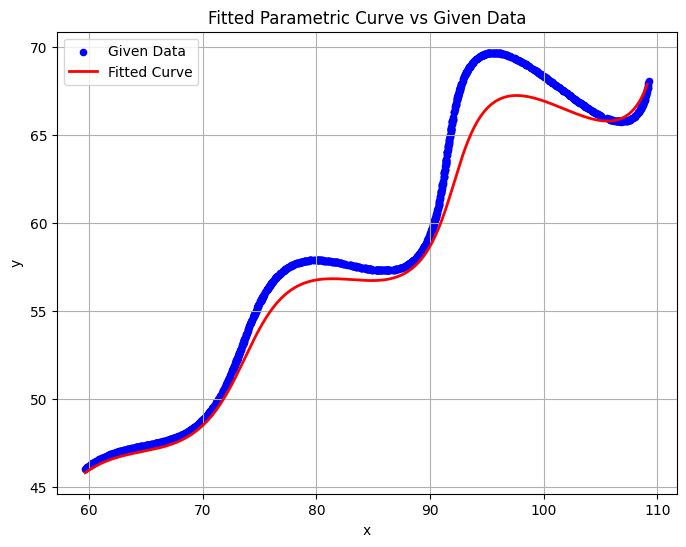

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


data = pd.read_csv("/kaggle/input/flam-dataset/xy_data.csv")  
x_data = data["x"].values
y_data = data["y"].values


num_points = len(data)
t_data = np.linspace(6, 60, num_points)

def parametric_equations(params, t):
    theta, M, X = params
    theta_rad = np.deg2rad(theta)
    x = (t * np.cos(theta_rad) - np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.sin(theta_rad) + X)
    y = (42 + t * np.sin(theta_rad) + np.exp(M * np.abs(t)) * np.sin(0.3 * t) * np.cos(theta_rad))
    return x, y

def loss(params):
    x_pred, y_pred = parametric_equations(params, t_data)
    return np.sum(np.abs(x_pred - x_data) + np.abs(y_pred - y_data))


initial_guess = [25, 0, 50]  # theta, M, X
bounds = [(0, 50), (-0.05, 0.05), (0, 100)]


result = minimize(loss, initial_guess, bounds=bounds, method='L-BFGS-B')


theta_opt, M_opt, X_opt = result.x
print("Optimized parameters:")
print(f"Theta (deg): {theta_opt:.4f}")
print(f"M: {M_opt:.5f}")
print(f"X: {X_opt:.4f}")

x_fit, y_fit = parametric_equations(result.x, t_data)
plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, label="Given Data", color="blue", s=20)
plt.plot(x_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fitted Parametric Curve vs Given Data")
plt.grid(True)
plt.show()
